In [2]:
# !pip install tensorflow-datasets
# !pip install -U tfds-nightly

In [3]:
# !pip install -U --pre tensorflow=="2.1"
!pip install tf_slim

In [4]:
!pip install pycocotools

In [5]:
# !pip install tensorflow==2.1


In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display



In [7]:
import os
import pathlib


if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [8]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.

object_detection/protos/input_reader.proto:5:1: warning: Import object_detection/protos/image_resizer.proto is unused.


In [9]:
%%bash 
cd models/research
pip install .

Processing /home/jupyter/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1303813 sha256=8842e5ebf83e61175b666f7d5505454fc29e529d9ecad967dc230d5b211dfe38
  Stored in directory: /tmp/pip-ephem-wheel-cache-1heng7sh/wheels/f2/6d/63/3db30458d91a6a8eb60864a478d42c02a58349cf168366d8e9
Successfully built object-detection
  Attempting uninstall: object-detection
    Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


In [10]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [11]:
import tensorflow_datasets as tfds


In [12]:
# ds = tfds.load('kitti', split='train',data_dir='/content/tensorflow_datasets', shuffle_files=True)
# assert isinstance(ds, tf.data.Dataset)
# print(ds)

In [13]:
# !gcloud auth login application-default



In [14]:
!gcloud config set account application-default

Updated property [core/account].


In [15]:
# from google.colab import auth
# auth.authenticate_user()

In [16]:
# !gcloud auth login dissertation-0




In [17]:
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    split=['train', 'test'],
#     shuffle_files=True,
    # as_supervised=True,
#     try_gcs=True,
    with_info=True,
    download=False,
#     data_dir='./tensorflow_datasets'
    data_dir="gs://kitti-dataset-1"
)

# ds = tfds.load('kitti', split='train',data_dir='/content/tensorflow_datasets')


In [18]:
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

  model_dir = pathlib.Path(model_dir)/"saved_model"

  model = tf.saved_model.load(str(model_dir))
  model = model.signatures['serving_default']

  return model

In [19]:
# model_name = 'faster_rcnn_resnet101_kitti_2018_01_28'
# model_name = 'faster_rcnn_inception_v2_coco_2018_01_28'
model_name = 'faster_rcnn_nas_lowproposals_coco_2018_01_28'
detection_model = load_model(model_name)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [20]:
# List of the strings that is used to add correct label for each box.

# PATH_TO_LABELS = 'models/research/object_detection/data/kitti_label_map.pbtxt'
PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)


In [21]:
# ds_train =ds 

In [22]:
def normalize_img(object):
  print(object['objects'])
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(object['image'], tf.float32) / 255., object['objects']['bbox']



In [23]:
# ds_train = ds_train.map(
#     normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
# ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
# ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [24]:
ds_train

<PrefetchDataset shapes: {image: (None, None, 3), image/file_name: (), objects: {alpha: (None,), bbox: (None, 4), dimensions: (None, 3), location: (None, 3), occluded: (None,), rotation_y: (None,), truncated: (None,), type: (None,)}}, types: {image: tf.uint8, image/file_name: tf.string, objects: {alpha: tf.float32, bbox: tf.float32, dimensions: tf.float32, location: tf.float32, occluded: tf.int64, rotation_y: tf.float32, truncated: tf.float32, type: tf.int64}}>

In [25]:
# ds_test = ds_test.map(
#     normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [26]:
print(detection_model.inputs)



[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]


In [27]:
detection_model.output_dtypes

{'num_detections': tf.float32,
 'detection_classes': tf.float32,
 'detection_boxes': tf.float32,
 'detection_scores': tf.float32}

In [28]:
detection_model.output_shapes

{'num_detections': TensorShape([None]),
 'detection_classes': TensorShape([None, 20]),
 'detection_boxes': TensorShape([None, 20, 4]),
 'detection_scores': TensorShape([None, 20])}

In [29]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  output_dict = model(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

In [30]:
def process_image(image):
  

    image_np = np.copy(image) #TODO: make more efficent 
    
    output_dict = run_inference_for_single_image(detection_model, image_np)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=1)
    return image_np

In [31]:
def show_inference(model, tensor):
  
  
    image_np = np.array(tensor)
    image =process_image(image_np)
    display(Image.fromarray(image))

['image', 'image/file_name', 'objects']
tf.Tensor([[-1.77  1.66 26.96]], shape=(1, 3), dtype=float32)


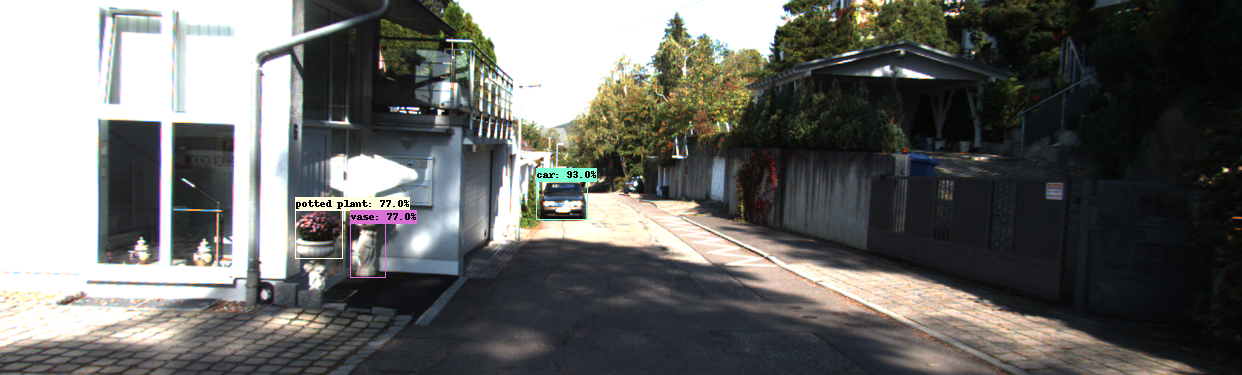

['image', 'image/file_name', 'objects']
tf.Tensor(
[[ -1.21   1.33  41.37]
 [ -4.82   1.62   7.06]
 [ -8.1    1.56  16.71]
 [ -8.29   1.5   22.67]
 [ -4.59   1.51  19.8 ]
 [ -4.66   1.39  31.76]
 [ -5.39   1.41  42.98]
 [-11.46   1.55  18.29]], shape=(8, 3), dtype=float32)


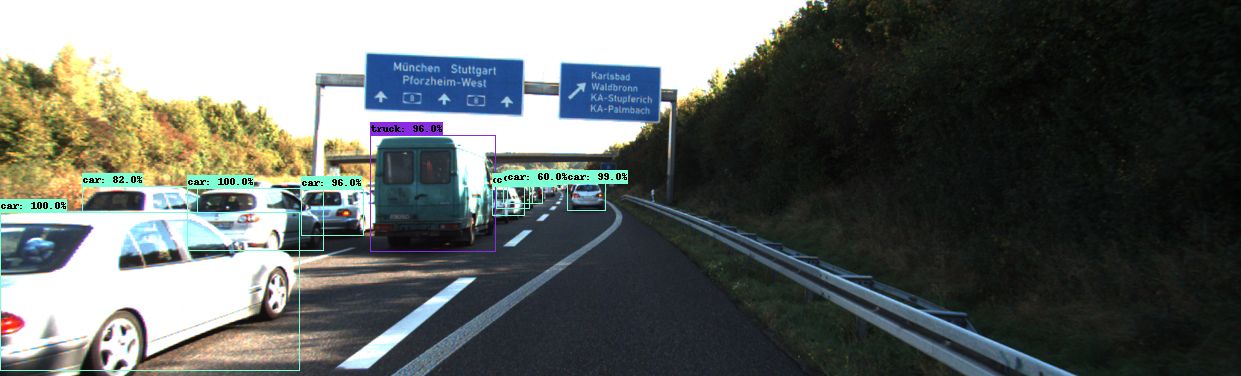

['image', 'image/file_name', 'objects']
tf.Tensor(
[[ 4.02  1.7  71.99]
 [-9.46  2.06 15.06]
 [10.76  1.25 19.96]], shape=(3, 3), dtype=float32)


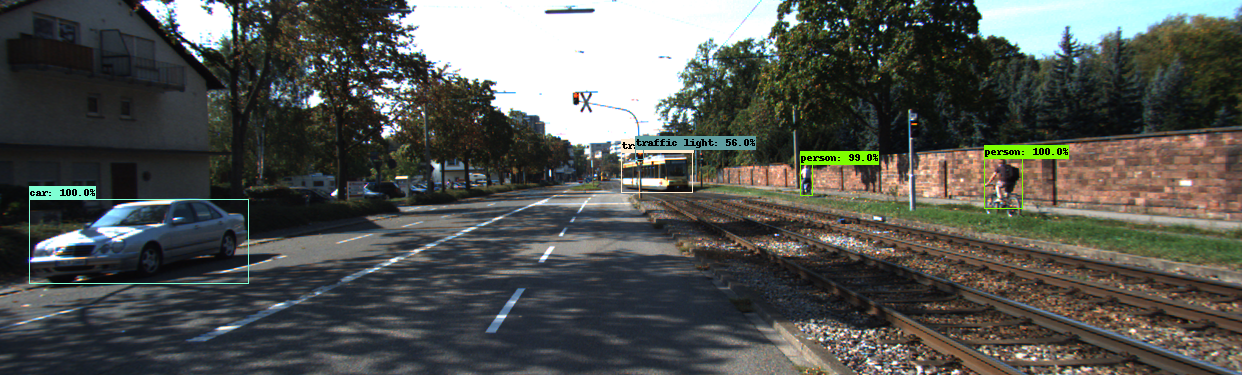

In [32]:
for example in ds_test.take(3):  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    print(list(example.keys()))
    image = example["image"]
    objects = example["objects"]
  
    print(objects['location'])
    show_inference(detection_model, image)




In [33]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    version=3.2.0,
    description='Kitti contains a suite of vision tasks built using an autonomous driving
platform. The full benchmark contains many tasks such as stereo, optical flow,
visual odometry, etc. This dataset contains the object detection dataset,
including the monocular images and bounding boxes. The dataset contains 7481
training images annotated with 3D bounding boxes. A full description of the
annotations can be found in the readme of the object development kit readme on
the Kitti homepage.',
    homepage='http://www.cvlibs.net/datasets/kitti/',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
            'dimensions': Tensor(shape=(3,), dtype=tf.float32),
            'location': Tensor(shape=(3,), dtype

In [34]:
#Evaluation Steps


from object_detection import eval_util
from object_detection.core import standard_fields as fields
from object_detection.metrics import coco_evaluation
from object_detection.protos import eval_pb2
from object_detection.utils import test_case
from object_detection.utils import tf_version

def test_get_eval_metric_ops_for_coco_detections(eval_dict, batch_size=1,
                                               max_gt_boxes=None,
                                               scale_to_absolute=False):
    eval_config = eval_pb2.EvalConfig()
    eval_config.metrics_set.extend(['pascal_voc_detection_metrics'])
    categories = list(category_index.values())

    metric_ops = eval_util.get_eval_metric_ops_for_evaluators(
        eval_config, categories, eval_dict)
    _, update_op = metric_ops['DetectionBoxes_Precision/mAP']

    with self.test_session() as sess:
        metrics = {}
        for key, (value_op, _) in six.iteritems(metric_ops):
            metrics[key] = value_op
        sess.run(update_op)
        metrics = sess.run(metrics)
        print(metrics)
  

In [35]:
#TODO: Complete Evaluation steps

input_data_fields = fields.InputDataFields
detection_fields = fields.DetectionResultFields

for example in ds_test.take(1):  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    print(list(example.keys()))
    image = example["image"]
    objects = example["objects"]
  
#     print( objects)
    print(objects['location'])
#     show_inference(detection_model, image)
    image_np = np.array(image)
    # Actual detection.
    output_dict = run_inference_for_single_image(detection_model, image_np)
    
#       return eval_util.result_dict_for_single_example(
#           image, key, detections, groundtruth,
#           scale_to_absolute=scale_to_absolute)


#     batch_size = 100
#     key = tf.constant([str(i) for i in range(batch_size)])

    key = tf.constant('image1')
    
    groundtruth_boxes = objects['bbox']
    groundtruth_classes = objects['type']
    groundtruth = {
        input_data_fields.groundtruth_boxes: groundtruth_boxes,
        input_data_fields.groundtruth_classes: groundtruth_classes,
      
    }
    
#     num_detections = tf.convert_to_tensor([len(output_dict['detection_classes'])])
    batch_size = 375
    num_detection = tf.ones([batch_size])
    detections = {
        detection_fields.detection_boxes:  output_dict['detection_boxes'],
        detection_fields.detection_scores: output_dict['detection_scores'],
        detection_fields.detection_classes: output_dict['detection_classes'],
        detection_fields.num_detections: num_detections
       
    }
    result_dict = eval_util.result_dict_for_single_example(image, key,detections, groundtruth)
#     test_get_eval_metric_ops_for_coco_detections(output_dict)

['image', 'image/file_name', 'objects']
tf.Tensor([[-1.77  1.66 26.96]], shape=(1, 3), dtype=float32)


NameError: name 'num_detections' is not defined

In [36]:
!pip install moviepy

In [7]:
tf.test.gpu_device_name()

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [38]:
from moviepy.editor import VideoFileClip

write_output = 'output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first n seconds
# clip1 = VideoFileClip("test.mp4").subclip(0,1)

clip1 = VideoFileClip("test.mp4")

white_clip = clip1.fl_image(process_image) 

white_clip.write_videofile(write_output, audio=False)

t:  10%|█         | 2/20 [00:39<01:41,  5.66s/it, now=None]

Moviepy - Building video output.mp4.
Moviepy - Writing video output.mp4




t:   0%|          | 51/10798 [09:05<32:25:23, 10.86s/it, now=None]

KeyboardInterrupt: 